In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import time

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

WINDOW = 22

In [6]:
df = pd.read_csv("../data/data_18_07.csv", delimiter=',', index_col=0)
splitFrame = pd.DataFrame(df.date_time.str.split(' ',1).tolist(), columns = ['date','time'],index = df.index)
df = pd.concat([splitFrame, df[df.columns[2:]]], axis=1)
df.head()

,date,time,open,close,low,high,volume,pair_id
#,,,,,,,,
1,2015-08-01,07:00:00.000000,284.000000,279.845023,275.724508,284.000000,301.376392,83
2,2015-08-02,07:00:00.000000,280.000000,286.438075,280.000000,286.438075,106.563859,83
3,2015-08-03,07:00:00.000000,285.438300,288.965644,284.286275,288.965644,75.706794,83
4,2015-08-04,07:00:00.000000,281.104486,288.000000,281.104486,288.000000,11.947218,83
5,2015-08-05,07:00:00.000000,288.200000,287.569800,279.793314,288.965425,9.297527,83


In [8]:
scaler = MinMaxScaler()

all_df = df.copy()

x = all_df['close'].copy()
y = all_df['close'].copy()

x = scaler.fit_transform(x.values.reshape(-1, 1))

y = scaler.fit_transform(y.values.reshape(-1, 1))

In [9]:
def load_data(X, seq_len, train_size=1):
    # Определяем число фич
    amount_of_features = X.shape[1] 
    
    sequence_length = seq_len + 1 
    data = []
    
    # Бьем тренировочные данные на блоки по размеру окна
    for index in range(len(X) + 1 - sequence_length):
        data.append(X[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    # Меняем размер входного фрейма на [dim, window, featureNumber]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    return x_train, y_train

X_train, y_train = load_data(x, WINDOW)

print (X_train.shape, y_train.shape)

(695, 22, 1) (695,)


In [10]:
def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

In [11]:
model = build_model(input_shape=(WINDOW, 1))

In [12]:
print('START FIT MODEL...')

model.fit(X_train, y_train, batch_size=32, epochs=500,
          verbose=0)

START FIT MODEL...


In [13]:
save_model(model, "../modelOneFeature/model_btc_close_oneFeature.h5")

In [177]:
model = load_model("../modelOneFeature/model_btc_close_oneFeature.h5")

In [14]:
trainPredict = model.predict(X_train)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])


trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 42.22 RMSE


In [15]:
prices = all_df.close.values.astype('float32')
prices = prices.reshape(len(prices), 1)

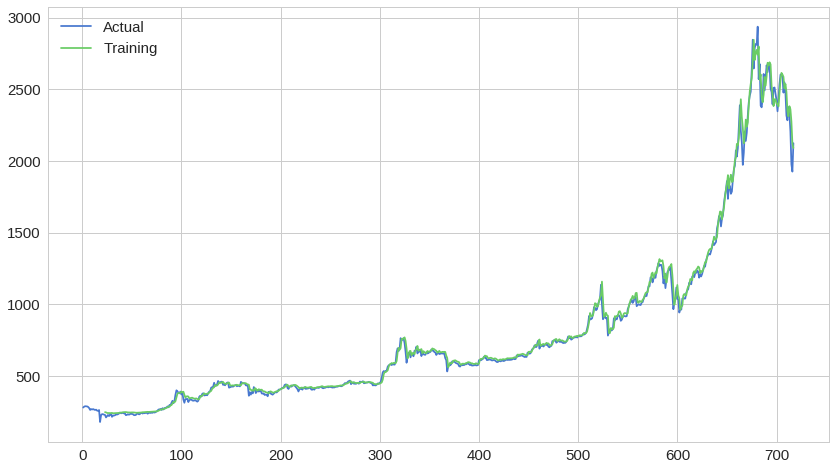

In [16]:
trainPredictPlot = np.empty_like(prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict

plt.plot(pd.DataFrame(prices, columns=["close"], index=all_df.index).close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.index).close, label='Training')
plt.legend(loc='best')
plt.show()


In [17]:
df.tail()

,date,time,open,close,low,high,volume,pair_id
#,,,,,,,,
713,2017-07-13,07:00:00.000000,2376.0000,2327.267142,2284.010000,2400.000000,3.287554e+07,83
714,2017-07-14,07:00:00.000000,2327.3000,2205.907300,2134.000000,2350.000000,3.329353e+07,83
715,2017-07-15,07:00:00.000000,2205.9073,1977.500000,1972.000010,2213.872903,5.927525e+07,83
716,2017-07-16,07:00:00.000000,1977.5000,1925.900000,1835.000277,2054.000000,6.640352e+07,83
717,2017-07-17,07:00:00.000000,1922.1933,2124.000000,1922.193300,2124.441007,3.881568e+07,83


In [19]:
# predict next day besides train data

alldata = scaler.fit_transform(df['close'].values)
data = (x[-WINDOW:]).reshape(1,22, 1)

res = model.predict([data])
next_day = scaler.inverse_transform(res)
print ('next day prediction: ', next_day)

next day prediction:  [[ 2255.28076172]]


/root/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/root/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [175]:
splitFrame = pd.DataFrame(df.date_time.str.split(' ',1).tolist(), columns = ['date','time'],index = df.index)
data = pd.concat([splitFrame, df[df.columns[2:]]], axis=1)

In [159]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

Actual = pd.DataFrame(prices, columns=["close"], index=all_df.index).close
Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.index).close
pred = pd.DataFrame(trainPredictPlot, columns=["close"], index=all_df.index).close

ActualValues = go.Scatter( x = data.date, y = Actual, name = 'ActualValues')
TrainingValues = go.Scatter( x = data.date, y = Training, name = 'TrainingValues')

iplot([ActualValues,TrainingValues])